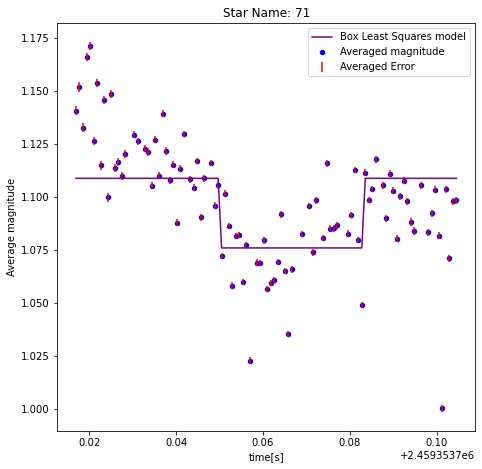

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astroutilities as util
import pprint
import warnings
import importlib
importlib.reload(util)

from numpy import sqrt
from astropy.timeseries import BoxLeastSquares, TimeSeries
from astropy.time import Time
from scipy.signal import medfilt 
from feets.preprocess import remove_noise
from feets import FeatureSpace, ExtractorWarning

## CONSTANTS ============================================================================

FILENAME = 'data/M3_raw01Photometry28-47-59.csv' # Change me to work with different files/filename
EXPOSURE_TIME = 2.5 # Seconds

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) # Need this to prevent it from spamming
warnings.filterwarnings("ignore", category=ExtractorWarning)
## FUNCTIONS ============================================================================

# I moved everything into astroutilities.py since this was getting extremely large

## CALCULATION ============================================================================

df = util.extract_data(FILENAME)

mags = df['mag'].to_numpy()
error = df['error_t'].to_numpy()

num_stars, samples = util.extract_samples_stars(df)
if 'jd' in df.columns:
    timeline = df['jd'].unique()
else: 
    timeline = np.linspace(0, samples*EXPOSURE_TIME, samples)


mags = np.reshape(mags, (samples, num_stars))      # Stack both mags and error according to time, new column = new file in time
error = np.reshape(error, (samples, num_stars))
diff_mags = util.subtract_all_magnitudes(mags)          # array of arrays, each array corresponding to a single star as the 'target'
uncertainties = util.calculate_all_uncertainties(error) # Each individual array is organized by incrementing time in columns, rows are stars
average_diff_mags = np.mean(diff_mags, axis=1, dtype=np.float64) # mean of every column, accumulating all stars at particular time
average_uncertainties = sqrt(np.sum(uncertainties**2, axis=1, dtype=np.float64))/uncertainties[0].shape[0] # sum of squares of each column, then sqrt'd

box_model_results = util.box_model_data(average_diff_mags, average_uncertainties, timeline=timeline)

# # Feature Extraction information
# indices = util.all_feets_indices(data = average_diff_mags, 
#                                 timeline = timeline, 
#                                 uncertainties= average_uncertainties)
# feature_df = pd.DataFrame(indices)
# feature_df.to_excel('Features_of_stars.xlsx')

# # Data export for Dr. Langill
# indices_of_stars = [ sub['name'] for sub in box_model_results]
# original_data_filtered = df.iloc[indices_of_stars]
# original_data_filtered.to_excel('Stars_with_varying_light.xlsx')

# Data testing, want to look at all our findings
test_index = 0
test_data = box_model_results[test_index]
test_mag = test_data['data']
test_uncert = test_data['uncertainty']
test_model = test_data['fitted_model']
test_time  = test_data['time']

# Plotting and whatnot
test_df = pd.DataFrame({'name': test_data['name'], 'average_magnitude': test_mag, 'average_uncertainty': test_uncert, 'time': test_time})
test_df.style.set_caption("Star number: %i" % test_data['name'])
ax = test_df.plot.scatter(x='time', y='average_magnitude', color='b', figsize=(7.5, 7.5), label='Averaged magnitude')
ax.plot(test_time, test_model, label='Box Least Squares model', color='purple')
ax.errorbar(x=test_df['time'], y=test_df['average_magnitude'], yerr=test_df['average_uncertainty'], fmt='none', color='r', label='Averaged Error')
ax.set_xlabel('time[jd]')
ax.set_ylabel('Average magnitude')
ax.set_title("Star Name: %i" % test_data['name'])
ax.legend()